In [1]:
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set to None to fetch from S3
census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_loc = None  # By default: 'local' if `census_uri` is a local path, `s3` if

# Slice 138 total datasets
start = 2
end = 7

n_epochs = 1
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000

# Misc
peek_dataset_lens = None  # When set, initialize loaders and print `len`s for the first [this many] datasets

# Plot configs
period = 10  # Color batch timings by this modulus (to highlight periodic artifacts)
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
census_loc = "s3-west-2"
census_uri = ""


In [4]:
if not census_uri:
    census_uri = None
if not census_loc:
    if census_uri and census_uri.startswith('/'):
        census_loc = 'local'
    else:
        census_loc = 'S3'
err(f'"{census_loc}" census, URI {census_uri}')

"s3-west-2" census, URI None


In [5]:
census = cellxgene_census.open_soma(uri=census_uri)

#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"
datasets =(census["census_info"]["datasets"]
           .read(column_names=["dataset_id"], value_filter=query_collection_id)
           .concat().to_pandas())["dataset_id"].tolist()
datasets[:10]

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [6]:
len(datasets)

138

In [7]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [8]:
@dataclass
class Exp:
    datapipe: ExperimentDataPipe
    loader: DataLoader

In [9]:
def get_exp_datapipe(start=None, end=None) -> Exp:
    ds = datasets[slice(start, end)]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

Optional: peek at `peek_dataset_lens` datasets' lengths:

In [10]:
%%time
if peek_dataset_lens:
    exps_prefix = [ get_exp_datapipe(start=i, n=1) for i in range(10) ]
    print([ exp.datapipe.shape[0] for exp in exps_prefix ])

CPU times: user 14 µs, sys: 4 µs, total: 18 µs
Wall time: 36.5 µs


In [11]:
@dataclass
class Batch:
    batch: float
    gc: Optional[float] = None

In [12]:
@dataclass
class Epoch:
    time_per_sample: float
    samples_per_sec: float
    batches: list[Batch]

In [13]:
@dataclass
class Method:
    name: str
    epochs: list[Epoch]

In [14]:
@dataclass
class Results:
    census: Method
    merlin: Optional[Method] = None
    mapped_collection: Optional[Method] = None

In [15]:
def benchmark(exp: Exp) -> Epoch:
    n_samples = exp.datapipe.shape[0]
    loader_iter = exp.loader.__iter__()
    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader_iter)
    
    num_iter = n_samples // BATCH_SIZE if n_samples is not None else None
    
    batches = []
    start_time = batch_time = time()
    
    total = num_iter if num_iter is not None else len(loader_iter)
    for i, batch in tqdm(enumerate(loader_iter), total=total):
        X = batch["x"] if isinstance(batch, dict) else batch[0] 
        # for pytorch DataLoader
        # Merlin sends to cuda by default
        if hasattr(X, "is_cuda") and not X.is_cuda:
            X = X.cuda()
        
        if num_iter is not None and i == num_iter:
            break

        batch_elapsed = time() - batch_time

        gc_time = None
        if i % 10 == 0:
            gc_before = time()
            gc.collect()
            gc_time = time() - gc_before

        batches.append(Batch(batch_elapsed, gc_time))
        batch_time = time()
    
    execution_time = time() - start_time
    gc.collect()
    
    time_per_sample = (1e6 * execution_time) / (total * BATCH_SIZE)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = total * BATCH_SIZE / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    
    return Epoch(samples_per_sec=samples_per_sec, time_per_sample=time_per_sample, batches=batches)

In [16]:
%%time
exp = get_exp_datapipe(start=start, end=end)
exp.datapipe.shape[0]

CPU times: user 8.56 s, sys: 2.28 s, total: 10.8 s
Wall time: 2.26 s


133790

## Run benchmark

In [17]:
%%time
epochs = []
for epoch in range(n_epochs):
    epoch = benchmark(exp)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

  0%|                                                                                            | 0/130 [00:00<?, ?it/s]

  1%|▋                                                                                   | 1/130 [00:00<01:16,  1.69it/s]

  2%|█▎                                                                                  | 2/130 [00:00<00:51,  2.48it/s]

  2%|█▉                                                                                  | 3/130 [00:01<00:42,  2.97it/s]

  3%|██▌                                                                                 | 4/130 [00:01<00:40,  3.13it/s]

  4%|███▏                                                                                | 5/130 [00:01<00:38,  3.25it/s]

  5%|███▉                                                                                | 6/130 [00:01<00:35,  3.45it/s]

  5%|████▌                                                                               | 7/130 [00:02<00:30,  4.04it/s]

  6%|█████▏                                                                              | 8/130 [00:02<00:26,  4.55it/s]

  7%|█████▊                                                                              | 9/130 [00:08<04:04,  2.02s/it]

  8%|██████▍                                                                            | 10/130 [00:08<02:55,  1.46s/it]

  8%|███████                                                                            | 11/130 [00:09<02:25,  1.22s/it]

  9%|███████▋                                                                           | 12/130 [00:09<01:54,  1.03it/s]

 10%|████████▎                                                                          | 13/130 [00:09<01:33,  1.25it/s]

 11%|████████▉                                                                          | 14/130 [00:10<01:15,  1.54it/s]

 12%|█████████▌                                                                         | 15/130 [00:10<00:57,  2.00it/s]

 12%|██████████▏                                                                        | 16/130 [00:10<00:44,  2.57it/s]

 13%|██████████▊                                                                        | 17/130 [00:10<00:36,  3.08it/s]

 14%|███████████▍                                                                       | 18/130 [00:14<02:34,  1.38s/it]

 15%|████████████▏                                                                      | 19/130 [00:14<01:51,  1.00s/it]

 15%|████████████▊                                                                      | 20/130 [00:14<01:20,  1.36it/s]

 16%|█████████████▍                                                                     | 21/130 [00:15<01:15,  1.44it/s]

 17%|██████████████                                                                     | 22/130 [00:15<01:00,  1.80it/s]

 18%|██████████████▋                                                                    | 23/130 [00:15<00:48,  2.19it/s]

 18%|███████████████▎                                                                   | 24/130 [00:16<00:41,  2.58it/s]

 19%|███████████████▉                                                                   | 25/130 [00:16<00:35,  2.94it/s]

 20%|████████████████▌                                                                  | 26/130 [00:16<00:30,  3.38it/s]

 21%|█████████████████▏                                                                 | 27/130 [00:21<03:04,  1.79s/it]

 22%|█████████████████▉                                                                 | 28/130 [00:21<02:11,  1.29s/it]

 22%|██████████████████▌                                                                | 29/130 [00:22<01:35,  1.06it/s]

 23%|███████████████████▏                                                               | 30/130 [00:22<01:10,  1.41it/s]

 24%|███████████████████▊                                                               | 31/130 [00:22<01:07,  1.46it/s]

 25%|████████████████████▍                                                              | 32/130 [00:23<00:57,  1.71it/s]

 25%|█████████████████████                                                              | 33/130 [00:23<00:49,  1.96it/s]

 26%|█████████████████████▋                                                             | 34/130 [00:23<00:40,  2.40it/s]

 27%|██████████████████████▎                                                            | 35/130 [00:23<00:31,  3.02it/s]

 28%|██████████████████████▉                                                            | 36/130 [00:23<00:25,  3.71it/s]

 28%|███████████████████████▌                                                           | 37/130 [00:29<02:46,  1.79s/it]

 29%|████████████████████████▎                                                          | 38/130 [00:29<01:58,  1.29s/it]

 30%|████████████████████████▉                                                          | 39/130 [00:29<01:26,  1.05it/s]

 31%|█████████████████████████▌                                                         | 40/130 [00:29<01:04,  1.39it/s]

 32%|██████████████████████████▏                                                        | 41/130 [00:30<01:02,  1.43it/s]

 32%|██████████████████████████▊                                                        | 42/130 [00:30<00:50,  1.76it/s]

 33%|███████████████████████████▍                                                       | 43/130 [00:30<00:41,  2.08it/s]

 34%|████████████████████████████                                                       | 44/130 [00:31<00:33,  2.60it/s]

 35%|████████████████████████████▋                                                      | 45/130 [00:31<00:27,  3.09it/s]

 35%|█████████████████████████████▎                                                     | 46/130 [00:37<02:48,  2.01s/it]

 36%|██████████████████████████████                                                     | 47/130 [00:37<02:00,  1.45s/it]

 37%|██████████████████████████████▋                                                    | 48/130 [00:37<01:27,  1.07s/it]

 38%|███████████████████████████████▎                                                   | 49/130 [00:37<01:05,  1.24it/s]

 38%|███████████████████████████████▉                                                   | 50/130 [00:37<00:51,  1.56it/s]

 39%|████████████████████████████████▌                                                  | 51/130 [00:38<00:53,  1.47it/s]

 40%|█████████████████████████████████▏                                                 | 52/130 [00:39<00:43,  1.80it/s]

 41%|█████████████████████████████████▊                                                 | 53/130 [00:39<00:33,  2.29it/s]

 42%|██████████████████████████████████▍                                                | 54/130 [00:39<00:26,  2.88it/s]

 42%|███████████████████████████████████                                                | 55/130 [00:43<01:41,  1.35s/it]

 43%|███████████████████████████████████▊                                               | 56/130 [00:43<01:12,  1.02it/s]

 44%|████████████████████████████████████▍                                              | 57/130 [00:43<00:52,  1.39it/s]

 45%|█████████████████████████████████████                                              | 58/130 [00:43<00:39,  1.83it/s]

 45%|█████████████████████████████████████▋                                             | 59/130 [00:43<00:30,  2.34it/s]

 46%|██████████████████████████████████████▎                                            | 60/130 [00:43<00:24,  2.86it/s]

 47%|██████████████████████████████████████▉                                            | 61/130 [00:44<00:31,  2.20it/s]

 48%|███████████████████████████████████████▌                                           | 62/130 [00:44<00:26,  2.55it/s]

 48%|████████████████████████████████████████▏                                          | 63/130 [00:44<00:22,  3.00it/s]

 49%|████████████████████████████████████████▊                                          | 64/130 [00:44<00:17,  3.77it/s]

 50%|█████████████████████████████████████████▌                                         | 65/130 [00:48<01:30,  1.39s/it]

 51%|██████████████████████████████████████████▏                                        | 66/130 [00:49<01:04,  1.01s/it]

 52%|██████████████████████████████████████████▊                                        | 67/130 [00:49<00:46,  1.35it/s]

 52%|███████████████████████████████████████████▍                                       | 68/130 [00:49<00:34,  1.78it/s]

 53%|████████████████████████████████████████████                                       | 69/130 [00:49<00:26,  2.27it/s]

 54%|████████████████████████████████████████████▋                                      | 70/130 [00:49<00:22,  2.67it/s]

 55%|█████████████████████████████████████████████▎                                     | 71/130 [00:50<00:28,  2.04it/s]

 55%|█████████████████████████████████████████████▉                                     | 72/130 [00:50<00:25,  2.29it/s]

 56%|██████████████████████████████████████████████▌                                    | 73/130 [00:50<00:19,  2.88it/s]

 57%|███████████████████████████████████████████████▏                                   | 74/130 [00:55<01:34,  1.70s/it]

 58%|███████████████████████████████████████████████▉                                   | 75/130 [00:55<01:07,  1.23s/it]

 58%|████████████████████████████████████████████████▌                                  | 76/130 [00:56<00:48,  1.12it/s]

 59%|█████████████████████████████████████████████████▏                                 | 77/130 [00:56<00:35,  1.48it/s]

 60%|█████████████████████████████████████████████████▊                                 | 78/130 [00:56<00:26,  1.93it/s]

 61%|██████████████████████████████████████████████████▍                                | 79/130 [00:56<00:21,  2.36it/s]

 62%|███████████████████████████████████████████████████                                | 80/130 [00:56<00:18,  2.71it/s]

 62%|███████████████████████████████████████████████████▋                               | 81/130 [00:57<00:25,  1.91it/s]

 63%|████████████████████████████████████████████████████▎                              | 82/130 [00:57<00:19,  2.48it/s]

 64%|████████████████████████████████████████████████████▉                              | 83/130 [01:01<01:05,  1.39s/it]

 65%|█████████████████████████████████████████████████████▋                             | 84/130 [01:01<00:46,  1.01s/it]

 65%|██████████████████████████████████████████████████████▎                            | 85/130 [01:01<00:33,  1.35it/s]

 66%|██████████████████████████████████████████████████████▉                            | 86/130 [01:01<00:24,  1.78it/s]

 67%|███████████████████████████████████████████████████████▌                           | 87/130 [01:02<00:18,  2.29it/s]

 68%|████████████████████████████████████████████████████████▏                          | 88/130 [01:02<00:14,  2.87it/s]

 68%|████████████████████████████████████████████████████████▊                          | 89/130 [01:02<00:11,  3.45it/s]

 69%|█████████████████████████████████████████████████████████▍                         | 90/130 [01:02<00:10,  3.75it/s]

 70%|██████████████████████████████████████████████████████████                         | 91/130 [01:03<00:15,  2.57it/s]

 71%|██████████████████████████████████████████████████████████▋                        | 92/130 [01:03<00:11,  3.19it/s]

 72%|███████████████████████████████████████████████████████████▍                       | 93/130 [01:08<01:00,  1.64s/it]

 72%|████████████████████████████████████████████████████████████                       | 94/130 [01:08<00:42,  1.18s/it]

 73%|████████████████████████████████████████████████████████████▋                      | 95/130 [01:08<00:30,  1.16it/s]

 74%|█████████████████████████████████████████████████████████████▎                     | 96/130 [01:08<00:22,  1.53it/s]

 75%|█████████████████████████████████████████████████████████████▉                     | 97/130 [01:08<00:16,  1.98it/s]

 75%|██████████████████████████████████████████████████████████████▌                    | 98/130 [01:08<00:13,  2.41it/s]

 76%|███████████████████████████████████████████████████████████████▏                   | 99/130 [01:09<00:11,  2.77it/s]

 77%|███████████████████████████████████████████████████████████████                   | 100/130 [01:09<00:10,  2.93it/s]

 78%|███████████████████████████████████████████████████████████████▋                  | 101/130 [01:10<00:13,  2.11it/s]

 78%|████████████████████████████████████████████████████████████████▎                 | 102/130 [01:14<00:49,  1.78s/it]

 79%|████████████████████████████████████████████████████████████████▉                 | 103/130 [01:15<00:34,  1.29s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 104/130 [01:15<00:24,  1.06it/s]

 81%|██████████████████████████████████████████████████████████████████▏               | 105/130 [01:15<00:17,  1.41it/s]

 82%|██████████████████████████████████████████████████████████████████▊               | 106/130 [01:15<00:13,  1.84it/s]

 82%|███████████████████████████████████████████████████████████████████▍              | 107/130 [01:15<00:10,  2.17it/s]

 83%|████████████████████████████████████████████████████████████████████              | 108/130 [01:16<00:09,  2.39it/s]

 84%|████████████████████████████████████████████████████████████████████▊             | 109/130 [01:16<00:07,  2.64it/s]

 85%|█████████████████████████████████████████████████████████████████████▍            | 110/130 [01:16<00:06,  2.99it/s]

 85%|██████████████████████████████████████████████████████████████████████            | 111/130 [01:23<00:42,  2.23s/it]

 86%|██████████████████████████████████████████████████████████████████████▋           | 112/130 [01:23<00:28,  1.60s/it]

 87%|███████████████████████████████████████████████████████████████████████▎          | 113/130 [01:23<00:19,  1.18s/it]

 88%|███████████████████████████████████████████████████████████████████████▉          | 114/130 [01:23<00:14,  1.14it/s]

 88%|████████████████████████████████████████████████████████████████████████▌         | 115/130 [01:24<00:10,  1.47it/s]

 89%|█████████████████████████████████████████████████████████████████████████▏        | 116/130 [01:24<00:07,  1.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 117/130 [01:24<00:06,  2.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████▍       | 118/130 [01:24<00:04,  2.40it/s]

 92%|███████████████████████████████████████████████████████████████████████████       | 119/130 [01:25<00:04,  2.62it/s]

 92%|███████████████████████████████████████████████████████████████████████████▋      | 120/130 [01:25<00:03,  2.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████▎     | 121/130 [01:31<00:18,  2.04s/it]

 94%|████████████████████████████████████████████████████████████████████████████▉     | 122/130 [01:31<00:11,  1.47s/it]

 95%|█████████████████████████████████████████████████████████████████████████████▌    | 123/130 [01:31<00:07,  1.07s/it]

 95%|██████████████████████████████████████████████████████████████████████████████▏   | 124/130 [01:31<00:04,  1.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 125/130 [01:31<00:02,  1.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 126/130 [01:32<00:01,  2.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████  | 127/130 [01:32<00:01,  2.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [01:32<00:00,  3.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████▎| 129/130 [01:32<00:00,  4.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [01:32<00:00,  4.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [01:32<00:00,  1.40it/s]

time per sample: 698.30 μs
samples per sec: 1432.06 samples/sec
CPU times: user 1min 47s, sys: 53.6 s, total: 2min 41s
Wall time: 1min 41s


In [18]:
results_json_path = f'results-{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results-s3-west-2.json


In [19]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [20]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df.index.name = 'idx'
if period:
    df['res'] = df.index % period
    df['res_str'] = df.res.astype('str') + f'mod{period}'
df = df.reset_index()
df

,idx,batch,gc,res,res_str
0,0,0.166440,0.454547,0,0mod10
1,1,0.272349,NaN,1,1mod10
2,2,0.257694,NaN,2,2mod10
3,3,0.292733,NaN,3,3mod10
4,4,0.288047,NaN,4,4mod10
...,...,...,...,...,...
125,125,0.128401,NaN,5,5mod10
126,126,0.139329,NaN,6,6mod10
127,127,0.127726,NaN,7,7mod10
128,128,0.133600,NaN,8,8mod10


In [21]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch,gc,res,res_str
8,8,5.989315,NaN,8,8mod10
17,17,3.849473,NaN,7,7mod10
26,26,5.272190,NaN,6,6mod10
36,36,5.323600,NaN,6,6mod10
45,45,5.933150,NaN,5,5mod10
54,54,3.691320,NaN,4,4mod10
64,64,4.018940,NaN,4,4mod10
73,73,4.840532,NaN,3,3mod10
82,82,3.689717,NaN,2,2mod10
92,92,4.718667,NaN,2,2mod10


In [22]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-s3-west-2.png


Returning IPython Image


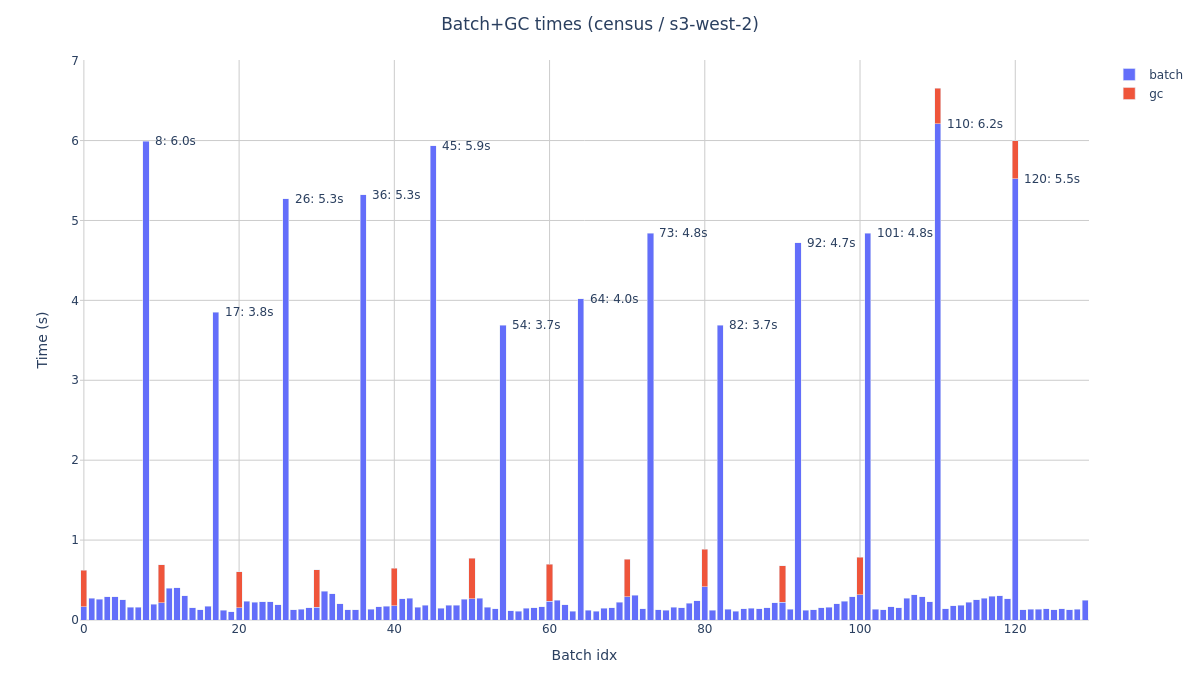

In [23]:
fig = px.bar(
    df.set_index('idx')[['batch', 'gc']],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)